<h1>Structural Variant Calling Validation Tutorial</h1>

In this tutorial we will demonstrate how Oxford Nanopore Technologies performs benchmarking of structural variant calls in the case of human samples. The methods presented are derived from those used in the Genome in a Bottle project.

The notebook will demonstrate the extent to which structural variant calling can be achieved using recommended variant calling tools from Oxford Nanopore Technologies and third parties. We will examine the outputs of these workflows and show how to compare results to independently provided truth sets. The present notebook does not itself explore in detail the process of calling structural variants.

Computational requirements for this tutorial include:

* Computer running the **EPI2ME Labs** notebook Server
* At least 16Gb RAM

> ⚠️ **Warning:** This notebook has been saved with its outputs for demonstration purposed. It is recommeded to select `Edit > Clear all outputs` before using the notebook to analyse your own data.

## Structural Variation calling with lra and cuteSV

> ***The code snippets in this section are illustrate the variant calling process, they are not intended to be executed from the notebook environment.***

Before discussing the benchmarking of structural variation calling, we will outline briefly how the variant calls used within the benchmarking demonstration below
we calculated. The dataset is publicly available and was sequenced from a library prepared from the GM24385 cell line. This genetic reference information was also
used by the GIAB consortium in their preparation of reference information. More information about this dataset can be found at:
[November 2020 GM24385 Dataset Release](https://nanoporetech.github.io/ont-open-datasets/gm24385_2020.11/).

The structural variants calculated from this sequence collection have been prepared using version 2.0 of the [pipeline-structural-variation](https://github.com/nanoporetech/pipeline-structural-variation) workflow. This workflow performs,

* read to reference alignment using [LRA](https://github.com/ChaissonLab/LRA)
* variant calling using [cuteSV](https://github.com/tjiangHIT/cuteSV)
* filtering based on minimum read support and SV size.

The pipeline was run using its default settings as follows:

    # activate the conda environment containing the pipeline code (see code repository for more information)
    cd pipeline-structural-variation-v2
    conda activate pipeline-structural-variation-v2
    
    # download and decompress reference file
    wget http://ftp-trace.ncbi.nih.gov/1000genomes/ftp/technical/reference/human_g1k_v37.fasta.gz
    gunzip human_g1k_v37.fasta.gz
    
    # download the basecalls from a single PromethION flowcell
    wget ...need https link for s3://ont-open-data/gm24385_2020.11/analysis/r9.4.1/20201026_1644_2-E5-H5_PAG07162_d7f262d5/guppy_v4.0.11_r9.4.1_hac_prom/basecalls.fastq.gz .
    
    # run the pipeline
    snakemake call --config input_fastq=basecalls.fastq.gz reference_fasta=human_g1k_v37.fasta threads=76 sample_name=PAG07162-hg37

The useful output for our purposes is a single [Variant Call Format](https://en.wikipedia.org/wiki/Variant_Call_Format) file containing the called variants.

## Benchmarking Structural Variation Calling

Benchmarking is the process of empirically comparing and contrasting results from different analysis methologies that analyse the same dataset and compare the results against a reference standard.
    
### What is a truth set?
    
A truth set is a canonical "answer" against which experimental results should be compared against. In this case we are using a truth set generated by the Genome in a Bottle consortium (GIAB). The objective of GIAB was to prepare a establish a reference view of the "true" variation in the human genome. This was achieved by measuring genetic variation using a variety of contemporary methods and the results were curated to establish a reference resource describing the measured variation between the reference human genome (GRCh37) and the GM24385 data. These results were presented in [A robust benchmark for detection of germline large deletions and insertions](https://rdcu.be/b4UMa). Structural variation is an emerging field in the study of genetic variation.
    
There are some important caveats to consider with the GIAB truth set. The first is that SV calls are biased towards the regions of the genome that are simpler to sequence, align and call. For this reason we are constraining this analysis to these high confidence calls. These regions are specified in a BED-format file which we will be downloading as part of this analysis. The next is that the truth set concerns only indels so there are no inversions or translocations in the truth set. Consequentially this benchmark will only be comparing insertion and deletion calls. Duplications are included in this analysis but are labelled as insertions in the truth set.
    
### Challenges of SV comparisons
    
One of the major challenges of SV benchmarking is that the changes are less atomic than for SNP comparisons. When comparing SNP variation the question is "simply" whether the same allelic difference is observed. In SV calling there is a need to consider whether the size, repeat number, and the position of a variant matches e.g. is a 90 base deletion at a given locus correctly identified if the truth set describes a deletion of 100 bases? How should we assess performance if the size of a measured deletion is the same but the truth set variation is located at a position that is shifted by a few nucleotides. Structural variants also tend to overlap the repetitive regions of the genome. This means that anchoring a variant to precise coordinates can be complicated by the overarching structures of nested insertions/ deletions within the repetive region.
    
Another challenge for comparing SV calling performance is the dearth of reference information. While it is acknowledged that SVs have an important role in disease and development the statistical methods and technologies for their identification are still emerging and it is likely that real SVs are missing from the currently available truth sets - we are constrained by the catalogues of known and validated variants.


### Getting Started

> ***The remainder of the notebook contains executable code snippets to be run within the notebook***

To get started benchmarking a structural variant callset, we will create a working directory:

In [1]:
import os
from epi2melabs import ping
pinger = ping.Pingu()
pinger.send_notebook_ping('start', 'sv_benchmarking')

# create a work directory and move into it
tutorial_name = "sv_benchmarking"
working_dir = "/epi2melabs/{}/".format(tutorial_name)
!mkdir -p "$working_dir"
%cd "$working_dir"

/epi2melabs/sv_benchmarking


To demonstrate the benchmarking process for small variant calls we will use a VCF created through the process outlined
above. This can be downloaded by running the following:

In [ ]:
!cecho ok "Downloading SV calls" 
for ext in (".vcf.gz", ".vcf.gz.tbi"):
    !wget --no-clobber -O PAG07162-hg37_cutesv_filtered$ext https://ont-open-data.s3.amazonaws.com/gm24385_2020.11/extra_analyses/sv_calling/PAG07162-hg37/sv_calls/PAG07162-hg37_cutesv_filtered$ext

!cecho ok "Downloading reference"
!wget --no-clobber -q -O human_g1k_v37.fasta.gz http://ftp-trace.ncbi.nih.gov/1000genomes/ftp/technical/reference/human_g1k_v37.fasta.gz

!cecho ok "Unzipping reference"
!gunzip -n -f human_g1k_v37.fasta.gz
!cecho ok "Done!"

We require also to download the GIAB truth set, which we can acquire from the GIAB resource in the NIST repository:

In [4]:
truth_name = "HG002_SVs_Tier1_v0.6"
for ext in (".vcf.gz", ".vcf.gz.tbi", ".bed"):
    !wget --no-clobber -q -O $truth_name$ext https://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_SVs_Integration_v0.6/$truth_name$ext

The above command will have download both the well validated truth variants and the specification of the high confidence regions.
As described in [A robust benchmark for detection of germline large deletions and insertions](https://rdcu.be/b4UMa) we consider
only the so-called "Tier 1" calls, the most accurate calls from the GIAB study. We note however that the GIAB project states:

> *We recommend using these calls critically, since they may contain false positives, false negatives, and inaccurate breakpoints and sequence predictions*

i.e. that these calls should not be implicitely trusted as a definitive truth, but that they represent the current best approximation
to such a truth.

### Analysis with Truvari

The recommended method for analysing structural variant calls with respect to a truthset is through the use of
[truvari](https://github.com/spiralgenetics/truvari). Comparison of a set of variant calls to a truthset would seem at first to be a rather
trivial affair: one must simply determined is a called variant is present or absent in the truth set, and vice-versa.
However as discussed above and in the GIAB paper, there are very many complicating factors and edge cases that must
be considered. It is for this reason that Oxford Nanopore Technologies' uses the same truvari toolset as recommended
by the GIAB project.

We will install `truvari` (together with a few other tools) into the EPI2MELabs notebook environment using the `pip` package manager

In [5]:
!pip install -q "Truvari==2.0.0.dev0" pytabix setproctitle scikit-allel

The first step of our benchmarking analysis is to normalise the VCF file output by the calling pipeline. The calling pipeline is capable
of generating duplication variants (`DUP`s); the GIAB truth set however does not make a distinction between duplication events and insertion
events (`INS`s). For this reason we will relabel all `DUP` variants in the SV calls as `INS` variants

In [ ]:
vcf = "PAG07162-hg37_cutesv_filtered.vcf.gz"
vcf_dupins = "PAG07162-hg37_cutesv_filtered_dup2ins.vcf.gz"
!cecho ok "Relabelling VCF"
!zcat "$vcf" \
    | sed 's/SVTYPE=DUP/SVTYPE=INS/g' \
    | bcftools view -i '(SVTYPE = "INS" || SVTYPE = "DEL")' \
    | bgzip > "$vcf_dupins"
!cecho ok "Indexing VCF"
!tabix -f "$vcf_dupins"

assert os.path.exists(os.path.join(working_dir, vcf_dupins)), f"Missing processed VCF: {vcf_dupins}"
!cecho ok "VCF pre-processing successful!"

With this minor inconvenience removed, we can now straighforwardly run truvari:

In [ ]:
# run truvari (expand to show code)
output_dir = "truvari"
input_vcf = vcf_dupins
truth_vcf = truth_name + ".vcf.gz"
truth_bed = truth_name + ".bed"
reference = "human_g1k_v37.fasta"
!rm -rf $output_dir
!cecho ok "Running truvari"
!truvari bench --passonly -b $truth_vcf --includebed $truth_bed --pctsim 0 -c $input_vcf -f $reference -o $output_dir
!cp $output_dir/tp-call.vcf $output_dir/tp.vcf
!cecho ok "Truvari run complete"

At the end of its execution `truvari` will have printed summary statistics concerning its comparison. These results are also available
within a text file formatted as [JSON](), and can be read with the `pandas` library:

In [8]:
import os
import json
import pandas as pd
summary = json.load(open(os.path.join(output_dir, "summary.txt")))
summary = pd.DataFrame.from_dict({k:[v] for k, v in summary.items()})
display(summary)

,TP-base,TP-call,FP,FN,precision,recall,f1,base cnt,call cnt,TP-call_TP-gt,TP-call_FP-gt,TP-base_TP-gt,TP-base_FP-gt,gt_precision,gt_recall,gt_f1
0,9415,9415,463,226,0.953128,0.976558,0.964701,9641,9878,9309,106,9309,106,0.942397,0.976298,0.959048


The full description of these fields is given in the [truvari documentation](https://github.com/spiralgenetics/truvari/wiki/bench), here we will focus
on just a few.

#### Interpretation of the results

With respect to a truth set the calling of variants in a genomic sample can be seen as a binary classification task: we have two classes of data, variants and non-variants. A standard method for summarizing this classification task is the measurement of the two quantities *precision* and *recall*, as summarized by the following [diagram](https://en.wikipedia.org/wiki/Precision_and_recall):

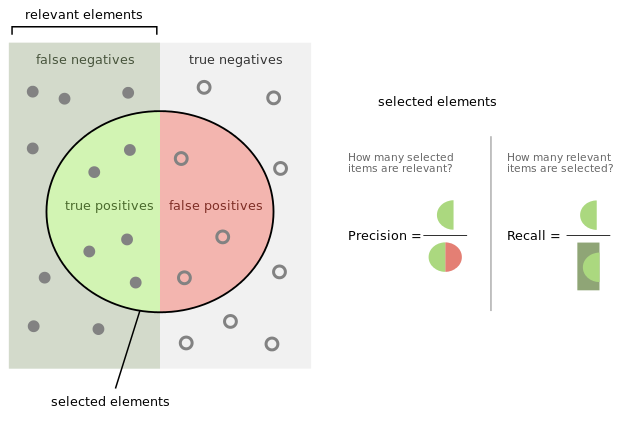

For our purposes the "relevant elements" are the variant loci and identities, while the remaining elements are locations in the genomic sample that contain the same sequence as the reference sequence. It is useful to note that neither *recall* nor *precision* take into account true negatives. This is the situation where a variant caller has correctly identified that the sample under consideration contains the same sequence as the reference. The metrics *recall* and *precision* thereby are sensitive only to loci identified as variants by the caller, and loci which are variant in the truthset. The vast majority of sequence within the GM24385 sample under consideration is structurally identical to that of the human reference sequence. Therefore values of precision and recall of e.g. 90% do not mean that there the error rate of the sequencing process and variant calling is on the order of 10%. Far from it in fact, even modestly high recall and precision numbers imply rather high sequencing quality.

With these considerations out of the way, let us focus on *precision* and *recall* from the above table. Truvari calculates this numbers from counts of variants classed as True Positive (TP), False Positive (TP), and False Negative (FN). It stores variants of these classes in three separate files, which we can read and aggregate into a single table:

In [9]:
# Aggregating truvari VCF files (click play)
import os

import allel
import pandas as pd
def parse_truvari(fname, classification):
    df = allel.vcf_to_dataframe(fname, fields='*', alt_number=1)
    df['classification'] = classification
    return df

dfs = list()
for classification in ("tp", "fp", "fn"):
    dfs.append(
        parse_truvari(
            os.path.join(output_dir, "{}.vcf".format(classification)),
            classification.upper()))
truvari = pd.concat(dfs)
display(truvari[['CHROM', 'POS', 'ID', 'classification', 'REF', 'ALT']].head())

,CHROM,POS,ID,classification,REF,ALT
0,1,9370182,cuteSV.DEL.482,TP,GGCCATCTGTGATGATGCCTCTGCACCTGCCGTGGGAAGGCCACAG...,G
1,1,102123452,cuteSV.DEL.3028,TP,TCTTCTTCTTCTTCTTCTTCTTCTTCTTCTTCTTCTTCTTCTTCTT...,T
2,1,205439856,cuteSV.DEL.5905,TP,TAAAATTTGAAAAATAATGCATGTTTAAATCTGTAAAATGGGCCAG...,T
3,1,9342574,cuteSV.INS.451,TP,C,CTCCTCCTTGTCTCCTCCTCCCTCTCCCCTTCCCCCTCCCCCTCCC...
4,1,93810422,cuteSV.INS.1241,TP,T,TTATATTATATATATATAAATATATATTATATATATATAATATATA...


The above code block will have displayed select columns from the combined `truvari` output to give a sense of the full table. From this data with a
little manipulation we can derive the same statistics for precision and recall as `truvari`'s JSON summary:

In [10]:
# Recapilulating truvari summary from full output (click play)

def add_statistics(df):
    # Adds recall, precision and f1 to a dataframe with TP, FP, and FN counts
    df['recall'] = df['TP'] * 100.0 / (df['TP'] + df['FP'])
    df['precision'] = df['TP'] * 100.0 / (df['TP'] + df['FN'])
    df['f1'] = 2 * ((df['recall'] * df['precision']) / (df['recall'] + df['precision']))
    return df

df = truvari.groupby(['SVTYPE'])
types = []
counts = []
for grp in df:
    types.append(grp[0])
    counts.append(grp[1]['classification'].value_counts())
df = pd.DataFrame(counts, index=types)
df.loc['All'] = df.sum()
df = add_statistics(df)
display(df)

,TP,FP,FN,recall,precision,f1
DEL,4154,143,45,96.672097,98.928316,97.787194
INS,5261,320,181,94.266261,96.674017,95.454958
All,9415,463,226,95.312816,97.655845,96.470106


Here we have additionally split the classification counts by insertion and deletion counts, something the `truvari` summary does not.
In addition to `precision` and `recall` we have calculated the [`f1`](https://en.wikipedia.org/wiki/F-score) statistic: the harmonic
mean of `precision` and `recall`. This statistic balances the recovery of true positive variants with the suppression of false
positives: maximising either one of `recall` or `precision` is possible at the expense of the other.

#### Analysis as a function of SV length

One of the key benefits of Nanopore sequencing over other sequencing methods is the obtained read length. Structural variants
can span hundreds (and thousands) of bases: nanopore sequencing is ideally suited for the accurate calling of these longer
variants.

With a little further manipulation of the `truvari` data table we can obtain the following:

In [11]:
# Calculating statistics as a function of length (click play)
import itertools
bin_borders = list(itertools.chain(
    range(-7500, -1000, 250), range(-1000, 0, 50),
    range(0, 1000, 50), range(1000, 7501, 250)))

# Prepare SV size bins
bins = pd.cut(truvari['SVLEN'], bin_borders)
df = truvari.groupby(['SVTYPE', bins], observed=True)
types = []
counts = []
for grp in df:
    types.append(grp[0])
    counts.append(grp[1]['classification'].value_counts())
index = pd.MultiIndex.from_arrays(
    list(zip(*types)), names=('SVTYPE', 'LEN'))
df = pd.DataFrame(counts, index=index).fillna(0)
for col in ('TP', 'FP', 'FN'):
    df[col] = df[col].astype(int)
df['count'] = df['TP'] + df['FN']
df = add_statistics(df)
df.reset_index(inplace=True)
pd.options.display.float_format = '{:,.2f}'.format
!cecho ok "Display shorter INS and DEL variants"
nrow = len(df)
display(df.iloc[nrow//2-5:nrow//2+5])

Display shorter INS and DEL variants


,SVTYPE,LEN,TP,FP,FN,count,recall,precision,f1
41,DEL,"(-250, -200]",129,4,2,131,96.99,98.47,97.73
42,DEL,"(-200, -150]",238,12,3,241,95.20,98.76,96.95
43,DEL,"(-150, -100]",440,14,8,448,96.92,98.21,97.56
44,DEL,"(-100, -50]",1380,88,20,1400,94.01,98.57,96.23
45,DEL,"(-50, 0]",57,0,0,57,100.00,100.00,100.00
46,INS,"(0, 50]",250,8,0,250,96.90,100.00,98.43
47,INS,"(50, 100]",1296,125,35,1331,91.20,97.37,94.19
48,INS,"(100, 150]",556,32,12,568,94.56,97.89,96.19
49,INS,"(150, 200]",313,13,11,324,96.01,96.60,96.31
50,INS,"(200, 250]",184,11,2,186,94.36,98.92,96.59


As this data table is fairly large a plot is worthwhile as this point:

In [12]:
# Plotting a summary of results (click play)
import aplanat
from aplanat import lines

from bokeh.models import Range1d, LinearAxis
from bokeh.plotting import figure
import numpy as np

from aplanat.util import Limiter

counts = df['count']
widths = df['LEN'].apply(lambda x: x.right) - df['LEN'].apply(lambda x: x.left)
counts = counts / widths * min(widths)
edges = df['LEN'].apply(lambda x: x.left).append(pd.Series(df['LEN'].iloc[-1].right), ignore_index=True)
mids = df['LEN'].apply(lambda x: 0.5 * (x.left + x.right))

p = figure(output_backend='webgl', height=300, width=600)
p.xaxis.axis_label = 'SV length / nucleotides'
p.yaxis.axis_label = 'Count true SVs'
p.extra_y_ranges = {"prcrec": Range1d(start=0, end=1)}
p.add_layout(LinearAxis(y_range_name="prcrec", axis_label='f1-score'), 'right')
p.line(x=mids, y=df['f1'] / 100, line_width=1.5, y_range_name='prcrec', color='red', alpha=0.4)
p.quad(
    top=counts, bottom=0, left=edges[:-1], right=edges[1:], alpha=0.6)

x_lim = Limiter((edges.iloc[0], edges.iloc[-1]))
y_lim = Limiter()
y_lim.fix(0, None)
y_lim.accumulate(counts)

p.x_range = Range1d(
    start=x_lim.min, end=x_lim.max, bounds=(x_lim.min, x_lim.max))
p.y_range = Range1d(
    start=y_lim.min, end=y_lim.max, bounds=(y_lim.min, y_lim.max))
p.text(x=[-4000, 4000], y=[800, 800], angle=0, text=['Deletions', 'Insertions'], text_align='center')

aplanat.show(p, background="#f4f4f4")

The plot depicts a histogram of the lengths of SVs within the truth set for both deletions (negative lengths) and insertions (positive lengths).
We plot also the f1-score (red line, right-hand scale) across the length range. At longer lengths the f1-score trace becomes appreciably noisy for
insertion calls. A factor in this is the low number of variant calls within both the truthset and the callset: any discrepancy between the two
datasets can lead to a large deviation from f1-score equaling unity. We might ask ourselves whether this indicates that the callset contains
errors at longer read lengths? To answer this question, we should keep in mind the recommendation from the GIAB project:

> *We recommend using these calls critically, since they may contain false positives, false negatives, and inaccurate breakpoints and sequence predictions*

## SV Visualisation

We will now look at some examplar individual variants using a genome viewer. For convenience we have created small subsets of the alignments to save downloading the full alignment file (~77GB). The EPI2MELabs environment notebook environment has the power to access the popular [Integrative Genomics Viewer](https://github.com/igvteam/igv.js) for viewing genomics data. 

Let us first download the focussed alignment data:

In [ ]:
# These alignments were generated with:
#      samtools view -hb <alignment> > <sample_alignment>.bam && samtools index <sample_alignment>.bam
bucket_url = "https://ont-exd-int-s3-euwst1-epi2me-labs.s3-eu-west-1.amazonaws.com/sv_benchmarking/"

for filename in ["PAG07162-hg37_lra-del-1_152544151-152602785.bam", "PAG07162-hg37_lra-small_del-5_1481729-1483822.bam"]:
    url = os.path.join(bucket_url, filename)
    path = os.path.join(working_dir, filename)
    !wget --no-clobber -O "$path" "$url"
    !wget --no-clobber -O "$path".bai "$url".bai

The code cell below will initialise the genome viewer loading the variant calls and truth set.

In [40]:
# create and display the genome viewer
import os
from igv_jupyterlab import IGV

genome = IGV.create_genome(
    name="Human (GRCh37)",
    fasta_url="/files/epi2melabs/sv_benchmarking/human_g1k_v37.fasta",
    index_url="/files/epi2melabs/sv_benchmarking/human_g1k_v37.fasta.fai")

vcf_track = IGV.create_track(
    name="Called variants", fmt="vcf",
    type="variant",
    url="/files/epi2melabs/sv_benchmarking/PAG07162-hg37_cutesv_filtered_dup2ins.vcf.gz",
    index_url="/files/epi2melabs/sv_benchmarking/PAG07162-hg37_cutesv_filtered_dup2ins.vcf.gz.tbi",
    autoHeight=True, minHeight=40, maxHeight=40)

truth_track = IGV.create_track(
    name="HG002 SV Tier1 variants", fmt="vcf",
    type="variant",
    url=f"/files/epi2melabs/sv_benchmarking/HG002_SVs_Tier1_v0.6.vcf.gz",
    index_url=f"/files/epi2melabs/sv_benchmarking/HG002_SVs_Tier1_v0.6.vcf.gz.tbi",
    autoHeight=True, minHeight=40, maxHeight=40)

bed_track = IGV.create_track(
    name="Confidence region", fmt="bed",
    type="annotation",
    url="/files/epi2melabs/sv_benchmarking/HG002_SVs_Tier1_v0.6.bed",
    displayMode='EXPANDED', autoHeight=True, minHeight=30, maxHeight=30)

igv = IGV(genome=genome, tracks=[bed_track, vcf_track, truth_track])
igv

IGV(id='igv_7602858', initialConfig={'id': 'igv_7602858', 'locus': '', 'tracks': [{'name': 'Confidence region'…

#### Case study 1: a heterozygous deletion variant

Running the code cell below will cause the genome browser above to display the region around a heterozygous deletion variant of the truthset:

In [45]:
# Move IGV to large deletion example (click play)
igv.remove_track("fp_example")
igv.remove_track("del_example")
del_bam_track = IGV.create_track(
    name="del_example", fmt="bam",
    url="/files/epi2melabs/sv_benchmarking/PAG07162-hg37_lra-del-1_152544151-152602785.bam",
    type="alignment",
    index_url="/files/epi2melabs/sv_benchmarking/PAG07162-hg37_lra-del-1_152544151-152602785.bam.bai",
    colorBy='strand',
    showMismatches=False,
    insertionColor="lilac")

igv.locus = "1:152,549,084-152,566,584"
igv.load_track(del_bam_track)

That the variant is called correctly by the calling pipeline is evidenced by the `Called variants` and `HG002 SV Tier1 variants` (the truth set) tracks: blue bars are show in each track. The dark blue bar indicates the presence of a variant while the lighter blue indicate that the genotype as being heterozygous.

#### Case study 2: a true variant missing from the truth set

The previous discussion regarding the truth set elucidated how the set might be fallible. The code cell below will move the genome browser to
a region around a variant call made my the pipeline which truvari has labelled as a false positive: a variant which is not present in the truth set. The alledged false positive call is a 76 pair deletion. This deletion was investigated independently and has been validated via orthogonal methods and found to be similarly present. That is to say in this case the truth set is incorrectly missing this variant.

In [46]:
# Move IGV to variant missing from truth set (click play)
igv.remove_track("fp_example")
igv.remove_track("del_example")
fp_example_bam_track = IGV.create_track(
    name="fp_example", fmt="bam",
    type="alignment",
    url="/files/epi2melabs/sv_benchmarking/PAG07162-hg37_lra-small_del-5_1481729-1483822.bam",
    index_url="/files/epi2melabs/sv_benchmarking/PAG07162-hg37_lra-small_del-5_1481729-1483822.bam.bai",
    colorBy='strand',
    showMismatches=False,
    insertionColor="lilac",
)
igv.load_track(fp_example_bam_track)
igv.locus = "5:1482400-1483000"

## Summary

In this tutorial we have demonstrated how Oxford Nanopore Technologies performs benchmarking of structural variant calling. The methods presented
follow those outlined by the Genome in a Bottle project. The tutorial is provided as an accompaniment to the
[November 2020 GM24385 Dataset Release](https://nanoporetech.github.io/ont-open-datasets/gm24385_2020.11/) of the
Oxford Nanopore Technologies Open Data website.

We have shown the tools used by Oxford Nanopore Technologies to assess the veracity of variant callers and to aid the development of new and improved methodologies.